# Install required packages

# Import required packages

In [24]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import warnings
from IPython.display import display

## Import dataset and data preprocessing

This section includes:
+ Downloading data from kaggle (_Note: In order to download dataset from Kaggle, you must first setup KaggleAPI._)
+ Data preprocessing
    + Removal of Irrelevant Variables
    + Handling of Missing Variables
    + Undersampling of Imbalanced Dataset

For in-depth analysis on data preprocessing, please refer to [Data Preprocessing Notebook](./1.0-data-preprocessing.ipynb).

### Setting up KaggleAPI

In order to use the Kaggle’s public API, you must first authenticate using an API token.

On Kaggle, go to 'Your Profile' > 'Settings' > 'Account' tab > 'API' section and select 'Create New Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials.

If you are using the Kaggle CLI tool, the tool will look for this token at `~/.kaggle/kaggle.json` on Linux, OSX, and other UNIX-based operating systems, and at `C:\Users\<Windows-username>\.kaggle\kaggle.json` on Windows. If the token is not there, an error will be raised. Hence, once you’ve downloaded the token, you should move it from your Downloads folder to this folder.

If you are using the Kaggle API directly, where you keep the token doesn’t matter, so long as you are able to provide your credentials at runtime.

### Running import and preprocessing script

In [25]:
sys.path.append('../scripts')
import data_preprocessing

data_preprocessing.data_preprocessing()

Base.csv found. Skipping the download and extraction process...
Data Preprocessing...
Data Preprocessing completed successfully. Data saved to 'data/processed/undersampled_data.csv'.
Splitting the dataset into train-test subset...
Train-test split completed successfully. Data saved to 'data/processed/X_train.csv', 'data/processed/X_test.csv', 'data/processed/y_train.csv', and 'data/processed/y_test.csv'.


In [26]:
# Read the CSV file into a DataFrame
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

## Feature Enginnering

New features are engineered and introduced into the dataset:

Hypothesis - **Device Activity** ([Hypothesis - Device Activity Notebook](./3.0-hypothesis-device-activity.ipynb))
+ `FE_01_device_os_emails_prob`
+ `FE_02_keep_alive_device_emails_prob`
+ `FE_03_source_foreign_request_prob`
+ `FE_04_device_os_foreign_request_prob`
+ `FE_05_device_os_prob`

Hypothesis - **K Means** ([Hypothesis - K Means Notebook](./3.0-hypothesis-account-kmeans.ipynb))
+ `have_prev_address`
+ `have_initial_bal`
+ `bank_integration`
+ `income_credit_limit_ratio`
+ `kmeans_prob`

Hypothesis - **Distinct Email Same DOB** ([Hypothesis - Distinct Email Same DOB Notebook](./3.0-hypothesis-distinct-email-same-dob.ipynb))
+ `emails_bin`
+ `name_email_similarity_bins`

Hypothesis - **Session Length** ([Hypothesis - Session Length Notebook](./3.0-hypothesis-session-length.ipynb))
+ `session_length_bins`

### Running feature engineering script

In [27]:
sys.path.append('../scripts')
import feature_engineering

# Suppress warnings
warnings.filterwarnings("ignore")

X_test_FE, y_test_FE = feature_engineering.feature_engineer(X_test, y_test)

# Reset warnings settings
warnings.resetwarnings()

Feature 1 created.
Feature 1 created.
Feature 3 created.
Feature 4 created.
Features for Device Activity Hypothesis generated.


# Fraud Detection Models

## Baseline Model

For our Baseline model, we employed a logistic regression approach to train on the entire dataset, with categorical variables one-hot encoded. Additionally, we implemented K-fold cross-validation during both model training and evaluation stages.

For more details on model training, refer to [Baseline Model Notebook](./4.0-baseline-model.ipynb).

### One-hot encoding for categorical variable in test dataset

In [28]:
### One-hot encoding of categorical features
# Split categorical and non-categorical variables
bm_test_cat = X_test.select_dtypes(include='object')
bm_test_non_cat = X_test.select_dtypes(exclude='object')

# Perform one-hot encoding on categorical variables
bm_test_one_hot_encoded = pd.get_dummies(bm_test_cat)

# Combine the non-categorical and one-hot encoded categorical variables
bm_X_test = pd.concat([bm_test_non_cat, bm_test_one_hot_encoded], axis=1)

bm_X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13194 entries, 0 to 13193
Data columns (total 51 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   income                            13194 non-null  float64
 1   name_email_similarity             13194 non-null  float64
 2   prev_address_months_count         13194 non-null  int64  
 3   current_address_months_count      13194 non-null  int64  
 4   customer_age                      13194 non-null  int64  
 5   days_since_request                13194 non-null  float64
 6   intended_balcon_amount            13194 non-null  float64
 7   zip_count_4w                      13194 non-null  int64  
 8   velocity_6h                       13194 non-null  float64
 9   velocity_24h                      13194 non-null  float64
 10  velocity_4w                       13194 non-null  float64
 11  bank_branch_count_8w              13194 non-null  int64  
 12  date

In [29]:
## Import trained model
with open('../models/baseline_model.pkl', 'rb') as file:
    baseline_model = pickle.load(file)

## Use the trained model to make predictions on the test set
bm_pred = baseline_model.predict(bm_X_test)

## Evaluate the performance of the baseline_model
# Compute accuracy
bm_accuracy = accuracy_score(y_test, bm_pred)
# Compute precision
bm_precision = precision_score(y_test, bm_pred)
# Compute recall
bm_recall = recall_score(y_test, bm_pred)
# Compute F1 score
bm_f1 = f1_score(y_test, bm_pred)

# Compute ROC curve and AUC
bm_fpr, bm_tpr, bm_thresholds = roc_curve(y_test, baseline_model.predict_proba(bm_X_test)[:,1])
bm_roc_auc = auc(bm_fpr, bm_tpr)

# Compute confusion matrix
bm_conf_matrix = confusion_matrix(y_test, bm_pred)


c:\Users\boomm\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\boomm\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


## Challenger Model

For more details on:
+ model analysis and selection
+ feature set analysis selection
+ model training

refer to [Challenger Model Notebook](./4.1-challenger-model.ipynb).


### One-hot enconding for categorical variables

In [30]:
### One-hot encoding of categorical features
# Split categorical and non-categorical variables
cm_test_cat = X_test_FE.select_dtypes(include=['object', 'category'])
cm_test_non_cat = X_test_FE.select_dtypes(exclude=['object', 'category'])

# Perform one-hot encoding on categorical variables
cm_test_one_hot_encoded = pd.get_dummies(cm_test_cat)

# Combine the non-categorical and one-hot encoded categorical variables
cm_X_test = pd.concat([cm_test_non_cat, cm_test_one_hot_encoded], axis=1)

cm_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13194 entries, 1054 to 12177
Data columns (total 76 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   income                               13194 non-null  float64
 1   name_email_similarity                13194 non-null  float64
 2   prev_address_months_count            13194 non-null  int64  
 3   current_address_months_count         13194 non-null  int64  
 4   customer_age                         13194 non-null  int64  
 5   days_since_request                   13194 non-null  float64
 6   intended_balcon_amount               13194 non-null  float64
 7   zip_count_4w                         13194 non-null  int64  
 8   velocity_6h                          13194 non-null  float64
 9   velocity_24h                         13194 non-null  float64
 10  velocity_4w                          13194 non-null  float64
 11  bank_branch_count_8w     

## Challenger Model 1

Extreme Gradient Boosting (XGBoost) with feature selection using LARS:

Selected features:
+ `income`
+ `name_email_similarity`
+ `prev_address_months_count`
+ `current_address_months_count`
+ `customer_age`
+ `days_since_request`
+ `intended_balcon_amount`
+ `zip_count_4w`
+ `velocity_6h`, `velocity_24h`, `velocity_4w`
+ `bank_branch_count_8w`
+ `date_of_birth_distinct_emails_4w`
+ `credit_risk_score`
+ `email_is_free`
+ `phone_home_valid`
+ `phone_mobile_valid`
+ `bank_months_count`
+ `has_other_cards`
+ `proposed_credit_limit`
+ `foreign_request`
+ `session_length_in_minutes`
+ `keep_alive_session`
+ `device_distinct_emails_8w`
+ `month`
+ `payment_type_AA`, `payment_type_AC`, `payment_type_AD`, `payment_type_AE`,
+ `employment_status_CA`, `employment_status_CB`, `employment_status_CC`, `employment_status_CE`, `employment_status_CF`, `employment_status_CG`,
+ `housing_status_BA`, `housing_status_BB`, `housing_status_BD`, `housing_status_BE`, `housing_status_BF`, `housing_status_BG`,
+ `source_TELEAPP`
+ `device_os_linux`, `device_os_macintosh`, `device_os_windows`, `device_os_x11`
+ `emails_bin_0-10`, `emails_bin_20-30`, `emails_bin_>30`

### Extract features for challenger model 1

In [31]:
# Extract features for challenger model 1
cm1_features = [
    'income', 'name_email_similarity', 'prev_address_months_count',
    'current_address_months_count', 'customer_age', 'days_since_request',
    'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
    'velocity_4w', 'bank_branch_count_8w',
    'date_of_birth_distinct_emails_4w', 'credit_risk_score',
    'email_is_free', 'phone_home_valid', 'phone_mobile_valid',
    'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
    'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
    'device_distinct_emails_8w', 'month', 'payment_type_AA',
    'payment_type_AC', 'payment_type_AD', 'payment_type_AE',
    'employment_status_CA', 'employment_status_CB', 'employment_status_CC',
    'employment_status_CE', 'employment_status_CF', 'employment_status_CG',
    'housing_status_BA', 'housing_status_BB', 'housing_status_BD',
    'housing_status_BE', 'housing_status_BF', 'housing_status_BG',
    'source_TELEAPP', 'device_os_linux', 'device_os_macintosh',
    'device_os_windows', 'device_os_x11', 'emails_bin_0-10',
    'emails_bin_20-30', 'emails_bin_>30'
]

cm1_X_test = cm_X_test.loc[:, cm1_features]
cm1_y_test = y_test_FE

In [32]:
## Import trained model
with open('../models/challenger_model_1.pkl', 'rb') as file:
    challenger_model1 = pickle.load(file)

## Use the trained model to make predictions on the test set
cm1_pred = challenger_model1.predict(cm1_X_test)

## Evaluate the performance of the baseline_model
# Compute accuracy
cm1_accuracy = accuracy_score(cm1_y_test, cm1_pred)
# Compute precision
cm1_precision = precision_score(cm1_y_test, cm1_pred)
# Compute recall
cm1_recall = recall_score(cm1_y_test, cm1_pred)
# Compute F1 score
cm1_f1 = f1_score(cm1_y_test, cm1_pred)

# Compute ROC curve and AUC
cm1_fpr, cm1_tpr, cm1_thresholds = roc_curve(cm1_y_test, challenger_model1.predict_proba(cm1_X_test)[:,1])
cm1_roc_auc = auc(cm1_fpr, cm1_tpr)

# Compute confusion matrix
cm1_conf_matrix = confusion_matrix(cm1_y_test, cm1_pred)

c:\Users\boomm\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\boomm\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


## Challenger Model 2

Adaptive Boosting (ADA Boost) with feature selection

Selected features:
+ `income`
+ `name_email_similarity`
+ `prev_address_months_count`
+ `current_address_months_count`
+ `customer_age`
+ `days_since_request`
+ `intended_balcon_amount`
+ `zip_count_4w`
+ `velocity_24h`, `velocity_4w`
+ `bank_branch_count_8w`
+ `date_of_birth_distinct_emails_4w`
+ `credit_risk_score`
+ `email_is_free`
+ `phone_home_valid`
+ `phone_mobile_valid`
+ `bank_months_count`
+ `has_other_cards`
+ `proposed_credit_limit`
+ `foreign_request`
+ `session_length_in_minutes`
+ `keep_alive_session`
+ `device_distinct_emails_8w`
+ `month`
+ `have_prev_address`
+ `bank_integration`
+ `income_credit_limit_ratio`
+ `payment_type_AC`
+ `employment_status_CA`, `employment_status_CB`, `employment_status_CC`
+ `housing_status_BA`, `housing_status_BE`
+ `device_os_linux`, `device_os_macintosh`, `device_os_windows`

### Extract features for challenger model 1

In [35]:
# Extract features for challenger model 1
cm2_features = [
    'income', 'name_email_similarity', 'prev_address_months_count',
    'current_address_months_count', 'customer_age', 'days_since_request',
    'intended_balcon_amount', 'zip_count_4w', 'velocity_24h', 'velocity_4w',
    'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
    'credit_risk_score', 'email_is_free', 'phone_home_valid',
    'bank_months_count', 'has_other_cards', 'proposed_credit_limit',
    'foreign_request', 'session_length_in_minutes', 'keep_alive_session',
    'device_distinct_emails_8w', 'month', 'have_prev_address',
    'bank_integration', 'income_credit_limit_ratio', 'payment_type_AC',
    'employment_status_CA', 'employment_status_CB', 'employment_status_CC',
    'housing_status_BA', 'housing_status_BE', 'device_os_linux',
    'device_os_macintosh', 'device_os_windows'
]

cm2_X_test = cm_X_test.loc[:, cm2_features]
cm2_y_test = y_test_FE

In [34]:
## Import trained model
with open('../models/challenger_model_2.pkl', 'rb') as file:
    challenger_model2 = pickle.load(file)

## Use the trained model to make predictions on the test set
cm2_pred = challenger_model2.predict(cm2_y_test)

## Evaluate the performance of the baseline_model
# Compute accuracy
cm2_accuracy = accuracy_score(cm2_y_test, cm2_pred)
# Compute precision
cm2_precision = precision_score(cm2_y_test, cm2_pred)
# Compute recall
cm2_recall = recall_score(cm2_y_test, cm2_pred)
# Compute F1 score
cm2_f1 = f1_score(cm2_y_test, cm2_pred)

# Compute ROC curve and AUC
cm2_fpr, cm2_tpr, cm2_thresholds = roc_curve(cm2_y_test, challenger_model2.predict_proba(cm2_y_test)[:,1])
cm2_roc_auc = auc(cm2_fpr, cm2_tpr)

# Compute confusion matrix
cm2_conf_matrix = confusion_matrix(cm2_y_test, cm2_pred)

c:\Users\boomm\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: node array from the pickle has an incompatible dtype:
- expected: [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]
- got     : {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}

## Model Ensemble

# Results

## Evaluation Metrics

(accuracy, precision, recall, F1 score)

In [39]:
# bm_accuracy
# bm_precision
# bm_recall
# bm_f1

# cm1_accuracy = 1
# cm1_precision = 1
# cm1_recall = 1
# cm1_f1 = 1

cm2_accuracy = 1
cm2_precision = 1
cm2_recall = 1
cm2_f1 = 1

em_accuracy = 1
em_precision = 1
em_recall = 1
em_f1 = 1

data = {
    'Model': ['Baseline', 'Challenger Model 1', 'Challenger Model 2', 'Ensemble Model'],
    'Accuracy': [bm_accuracy, cm1_accuracy, cm2_accuracy, em_accuracy],
    'Precision': [bm_precision, cm1_precision, cm2_precision, em_precision],
    'Recall': [bm_recall, cm1_recall, cm2_recall, em_recall],
    'F1 Score': [bm_f1, cm1_f1, cm2_f1, em_f1]
}

# Create the DataFrame
metrics_df = pd.DataFrame(data)

# Display the DataFrame
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Baseline,0.844399,0.586255,0.192096,0.289373
1,Challenger Model 1,0.309610,0.181651,0.909007,0.302794
2,Challenger Model 2,1.000000,1.000000,1.000000,1.000000
3,Ensemble Model,1.000000,1.000000,1.000000,1.000000


## AUC

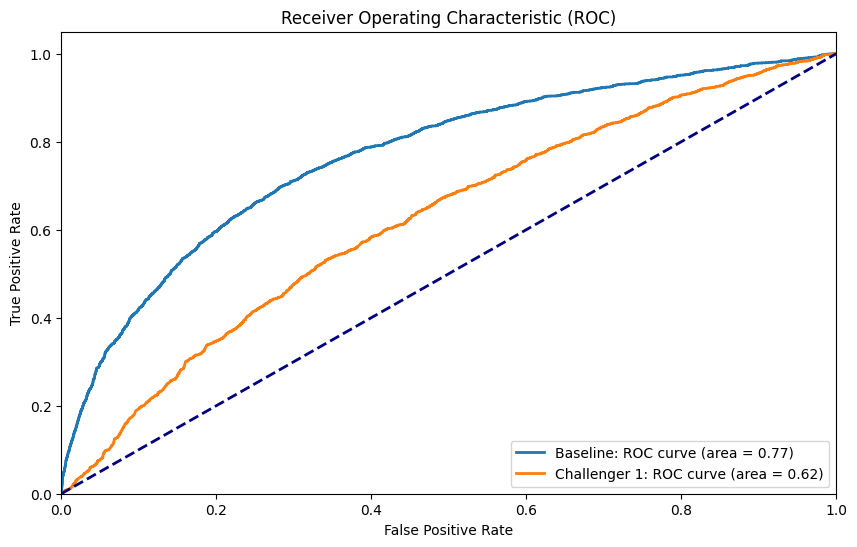

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(bm_fpr, bm_tpr, lw=2, label='Baseline: ROC curve (area = %0.2f)' % bm_roc_auc)
plt.plot(cm1_fpr, cm1_tpr, lw=2, label='Challenger 1: ROC curve (area = %0.2f)' % cm1_roc_auc)
# plt.plot(cm2_fpr, cm2_tpr, lw=2, label='Challenger 2: ROC curve (area = %0.2f)' % cm2_roc_auc)
# plt.plot(em_fpr, em_tpr, lw=2, label='Ensemble: ROC curve (area = %0.2f)' % em_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Confusion Matix

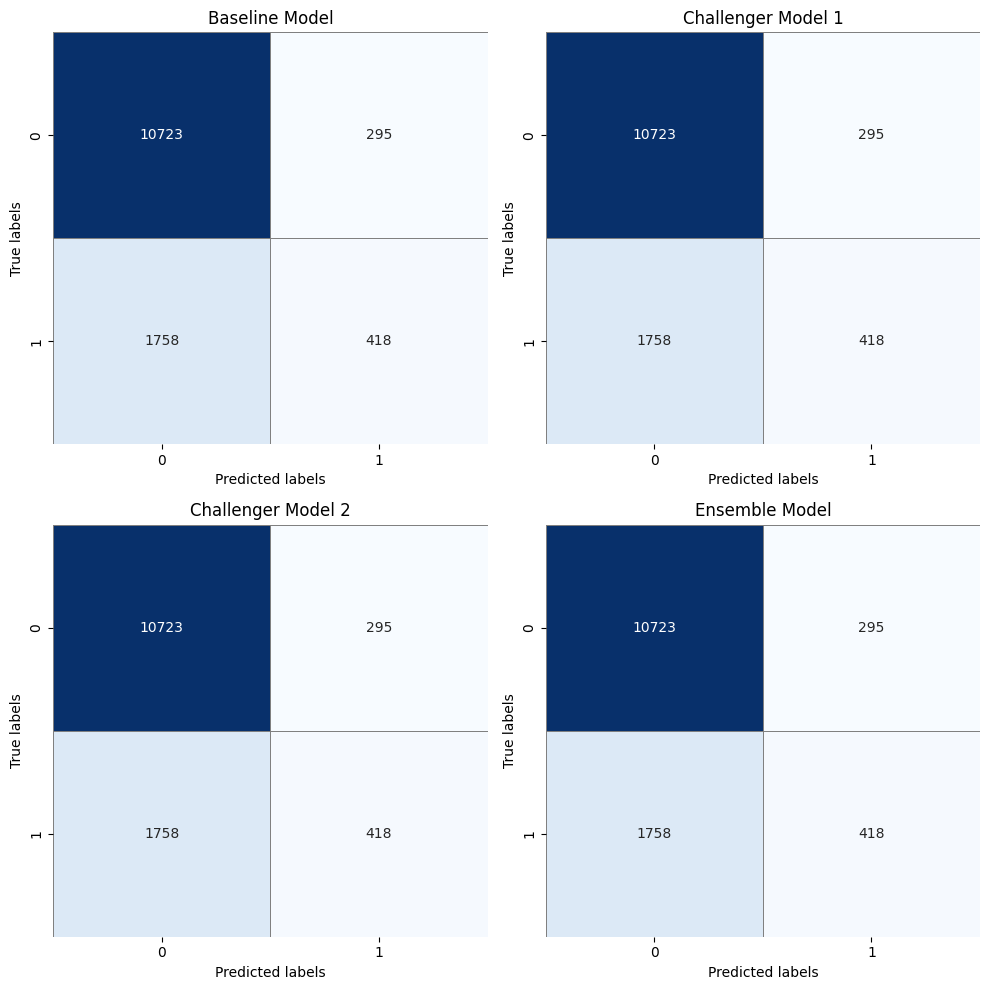

In [30]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.heatmap(bm_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Baseline Model')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(2, 2, 2)
sns.heatmap(cm1_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
# sns.heatmap(bm_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Challenger Model 1')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(2, 2, 3)
sns.heatmap(cm2_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
# sns.heatmap(bm_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Challenger Model 2')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.subplot(2, 2, 4)
# sns.heatmap(em_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
sns.heatmap(bm_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Ensemble Model')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.tight_layout()  # Adjust spacing between subplots for better layout
plt.show()

# Conclusion